# Introduction

Loading required libraries.

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import GPyOpt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from GPyOpt.methods import BayesianOptimization
from scipy.optimize import basinhopping #method for extra part

Loading dataset from sklearn library.

In [231]:
X, y = load_diabetes(return_X_y=True)

As next step, fitting Random Foresr Regressor on loaded data. Here and afterwards I am fixing random_state parameter equal to 7 to have an ability to reproduce same results.

In [232]:
rfreg = RandomForestRegressor(random_state=7)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

Calculating baseline error using cross validation score on loaded data and negative mean squared error.

In [233]:
baseline = cross_val_score(rfreg, X, y, scoring='neg_mean_squared_error').mean()
baseline

-3376.5277690628195

# Random Search

Here I am executing Random Search using RandomizedSearchCV from sklearn. I select 1000 iterations to have more points sampled and number of parallel jobs I set to 6 to speed up execution (I have 8 cores so maybe parameter need to be changed if executed on less amount of cores). Same as above, random state is set to value 7 and, last but not least, I add some verbosity not to get bored while waiting.

As for parameters dictionary, I choose to give a list of values to sample from for max_depth, n_estimators and max_features parameters because all those values should be an integer values. To avoid some random float numbers, I decided to go with list of possible values. Boundaries for max_depth and n_estimators I choose from to be aproximately equaly spread around best value retrieved on previous attempts. While boundaries for max_features array are derived from data X variale. Since in our data only 10 features I logically ,limit possible values between 1 and 10 (included).

In [234]:
params = dict(max_depth = np.arange(1, 21), n_estimators = np.arange(80, 121), max_features = np.arange(1,11))
rs = RandomizedSearchCV(rfreg, param_distributions=params, scoring='neg_mean_squared_error', n_iter=1000, n_jobs=6, verbose=3, random_state=7)
rs.fit(X,y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    3.1s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    8.3s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   16.5s
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:   27.8s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   43.1s
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 2580 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 3860 tasks      | elapsed:  3.4min
[Parallel(n_jobs=6)]: Done 4596 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done 5000 out of 5000 | elapsed:  4.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                           

Printing results of random search - best set of parameters, respective estimator and score.

In [238]:
rs.best_params_

{'n_estimators': 93, 'max_features': 4, 'max_depth': 9}

In [239]:
rs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=93, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [240]:
rs.best_score_

-3134.653779344906

# Grid Search

Next, I am executing Grid Search on loaded data. For parameters grid I choose intervals equally distributed around best parameters set, except for max_features parameter - here same logic applies - we have maximum 10 features so checking all values between 1 and 10. 

As before, I set number of parallel jobs to 6 for faster execution (since I have 8 cores on my laptop) and some level of verbosity to not get bored during execution. Number of iterations here depends on amount of possible parameters.

As for parameters dictionary, to select boundaries I first run Grid Search with wider interval and bigger step, once I rougly found best parameters values - I narrowed down search range and reduce step size. Current implementation done with reduced step size and more narrow intervals as result of previous runs.

In [241]:
params = dict(max_depth = np.arange(5, 16), n_estimators = np.arange(90, 111), max_features = np.arange(1,11))
gs = GridSearchCV(rfreg, param_grid=params, scoring='neg_mean_squared_error', n_jobs=6, verbose=3)
gs.fit(X,y)

Fitting 5 folds for each of 2310 candidates, totalling 11550 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   12.7s
[Parallel(n_jobs=6)]: Done 500 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   35.9s
[Parallel(n_jobs=6)]: Done 1140 tasks      | elapsed:   53.0s
[Parallel(n_jobs=6)]: Done 1556 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 2036 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 2580 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 3860 tasks      | elapsed:  3.2min
[Parallel(n_jobs=6)]: Done 4596 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 5396 tasks      | elapsed:  4.7min
[Parallel(n_jobs=6)]: Done 6260 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:  7.0min


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, r...
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=6,
     

Printing result of grid search - best set of parameters found, respective estimator and score.

In [242]:
gs.best_params_

{'max_depth': 9, 'max_features': 4, 'n_estimators': 93}

In [243]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=93, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

In [244]:
gs.best_score_

-3134.653779344906

# Bayesian Optimization

For Bayesian Optimization first of all we need to define a function which executes Random Forest Regressor fitting and calculates respective score. This function takes one argument which contains three values - one per respective parameter. 

In [245]:
def RFR(args):
    
    rfreg = RandomForestRegressor(max_depth=int(args[0][0]), n_estimators = int(args[0][1]), max_features = int(args[0][2]), random_state=7)
    rfreg.fit(X, y)
    score = cross_val_score(rfreg, X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

Now, I am ready to execute Bayesian Optimixzation itself. Since all parameters are should be an integer values I am using discrete type and domain as list of values which is simillar to the one used for Grid Search. As usual, adding verbosity to see interim results.

In [249]:
domains = [{'name':'max_depth', 'type':'discrete', 'domain': (5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)},
      {'name': 'n_estimators', 'type': 'discrete', 'domain': (90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110)}, 
      {'name':'max_features', 'type':'discrete', 'domain': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)}]

optimizer = BayesianOptimization(f=RFR, model_type='GP', acquisition_type='EI', domain=domains, maximize=True)
optimizer.run_optimization(max_iter=50, verbosity=True)

num acquisition: 1, time elapsed: 1.31s
num acquisition: 2, time elapsed: 2.74s
num acquisition: 3, time elapsed: 4.32s
num acquisition: 4, time elapsed: 5.54s
num acquisition: 5, time elapsed: 7.08s
num acquisition: 6, time elapsed: 8.36s
num acquisition: 7, time elapsed: 9.65s
num acquisition: 8, time elapsed: 11.00s
num acquisition: 9, time elapsed: 12.47s


Ploting cvonvergence using in-built method of optimizer from number of iterations.

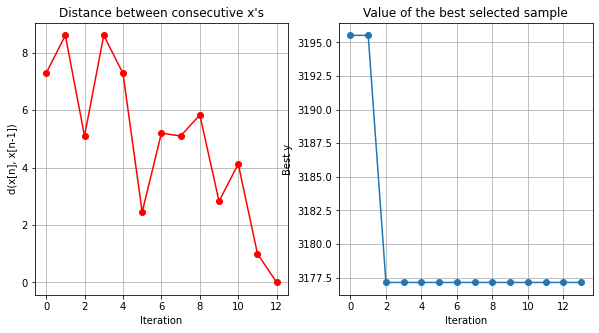

In [250]:
optimizer.plot_convergence()

Next, printint optimal parameters values as well as optimal score found.

In [257]:
print("Optimal parameters are max_depth = %d, n_estimators = %d and max_features = %d." % (optimizer.x_opt[0], optimizer.x_opt[1], optimizer.x_opt[2]))

print("Optimal function value is %.5f" % optimizer.fx_opt)

Optimal parameters are max_depth = 5, n_estimators = 95 and max_features = 6.
Optimal function value is 3177.14603


# Results

After all three methods are executed we could plot results on single plot to compare which of them find results faster and has a better result itself.

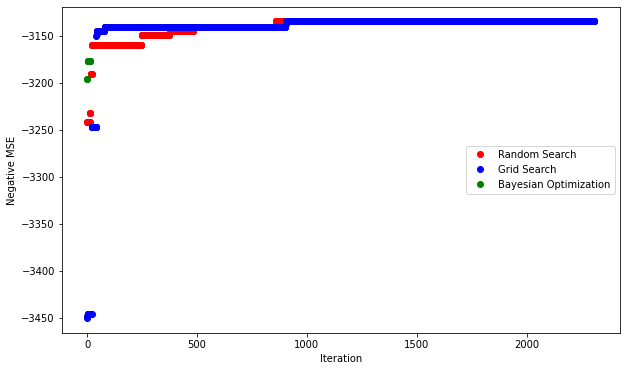

In [306]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_gs = np.maximum.accumulate(gs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

plt.figure(figsize=(10,6))
plt.plot(y_rs, 'ro', label='Random Search')
plt.plot(y_gs, 'bo', label='Grid Search')
plt.plot(y_bo, 'go', label='Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('Negative MSE')
plt.legend(loc='right')

From this plot we could see that Bayesian Optimization (BO) requires much less amount of iterations to find a solution. Number of iterations here much less than in Grid (GS) or Random Search (RS). However we could also notice that result itself is slightly worse compare to the one found by GS or RS - green dots on plot are below blue and red ones. On other hand, we could see that RS find suitable result a  bit earlier compare to GS. 

In a nutshell, GS method is slowest among three tested methods and goes through each set of values, but could be useful to pin point serach interval boundaries for other methods as I have did initially. RS method is faster compare to GS and could achieve same result, but here large number of iteration also required if we would like to get precise result. I have used 1000 instead of default 10 iterations. This makes this method not so efficient. The fastest method amongs tested ones is BO which achieve result much more faster and stop execution if improvement not that sufficient anymore. As result, optimal value a bit worse, but found much faster. I think BO method could be used to quickly identify where approximately optimal parameters values lies and, if better accuracy is required, other methods like RS or GS could be used afterwards with more granular steps. 

# Extra: Basin-hopping method optimization

Since Simulated Annealing got depricated in SciPy and replaces with Basin-hopping method I decided to use it for extra task. First of all I neeed to define simillar function as for Bayesian Optimization, but this time I do not need two dimansional arrayt for parameters hence function content remains same, I just changed it since parameters are passed differently. Another minor change - I return negative score since Basin-hopping method is seraching for minimal solution.

In [261]:
def RFR_BH(args):
    rfreg = RandomForestRegressor(max_depth=int(args[0]), n_estimators = int(args[1]), max_features = int(args[2]), random_state=7)
    rfreg.fit(X, y)
    score = cross_val_score(rfreg, X, y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return -1 * score

Because all out parameters shhould be integer values due to their nature and since they have logical constraints I have to define my custom stepper function with conditions not to violate such constraints. For max_depth and n_estimators we have lower possible value as 1 and no upper constraints, hence I limited in code possible steps not to go lower than 1 if such happens. While for max_features parameters value whould stay within interval from 1 to 10 included, hence conditions here includes also upper bound additionaly. Steps itself are choosen by my as best guess and value itself could be any random integer value within interval bound. When there is a risk to violate constraint, I set possible interval value to 0. 

In [262]:
class MyTakeStep(object):
    def __init__(self, stepsize=1):
        self.stepsize = stepsize #set to 1 to control it later per parameter with multiplication
    def __call__(self, x):
        s = self.stepsize
        if x[0] <= 5: # for max_depth parameter lower possible bound is 1 and no upper
            x[0] += np.random.randint(0, 6*s) # for step I choose any value between -5 and 5
        else:
            x[0] += np.random.randint(-5*s, 6*s)
        
        if x[1] <= 10: # for n_estimators parameter lower possible bound is 1 and no upper
            x[1] += np.random.randint(0, 11*s) # for step I choose any value between -10 and 10
        else:
            x[1] += np.random.randint(-10*s, 11*s)
        
        if x[2] <= 1: # for max_features parameter lower possible value is 1 and upper possible value is 10
            x[2] += np.random.randint(0, 2*s) # respectively step size is a value from set -1, 0 and 1
        elif x[2] >= 10:
            x[2] += np.random.randint(-1*s, s)
        else:
            x[2] += np.random.randint(-1*s, 2*s)
            
        return x

Since in SciPy OptimizeResult object doesn't hold array of value for each iteration I am defining custom callback function where I am collecting values of parameters and function value for each itertion. Later I will use those to create a plot simillar to previous one.

In [294]:
def print_fun(x, f, accept):
    all_x.append(x)
    all_y.append(f)

Now, defining optimizer itself and running optimization. I set number of iterations to 50 and stepsize as 1, but it wil be overruled by custom defined stepper class. Also, defining custom callback function to accumulate iterations results.

In [295]:
all_x = [] # initializing array to accumulate values
all_y = []
mytakestep = MyTakeStep() # creating custom stepper class
minimizer_kwargs = {"method": "BFGS"} # optimization method to be used
x0 = [10, 100, 5] # setting initial guess for parameters values - I choose some values as randomly and close to previous results
BH = basinhopping(RFR_BH, x0, minimizer_kwargs=minimizer_kwargs, niter=50, stepsize=1, take_step=mytakestep, callback=print_fun)

Printing result of optimization - optimal parameters values and respective function value.

In [303]:
print("Optimal parameters are max_depth = %d, n_estimators = %d and max_features = %d." % (BH.x[0], BH.x[1], BH.x[2]))
print("Optimal function value is %.5f" % BH.fun)

Optimal parameters are max_depth = 9, n_estimators = 76 and max_features = 4.
Optimal function value is 3139.88603


For simplicity, on the plot I am comparing Basin-hopping (BH) method with Bayesian Optimization (BO) only.

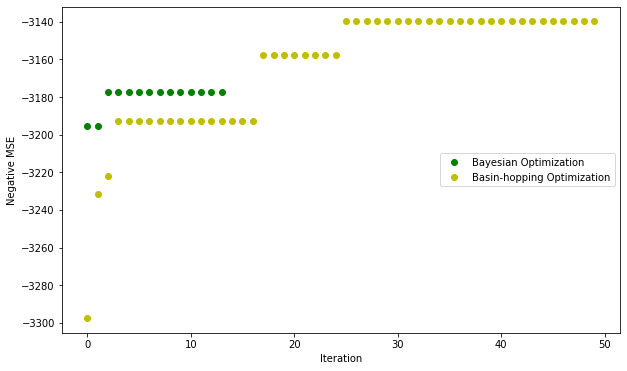

In [313]:
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()
y_bh = np.maximum.accumulate(-np.array(all_y))

plt.figure(figsize=(10,6))
plt.plot(y_bo, 'go', label='Bayesian Optimization')
plt.plot(y_bh, 'yo', label='Basin-hopping Optimization')
plt.xlabel('Iteration')
plt.ylabel('Negative MSE')
plt.legend(loc='right')

From this plot we could notice that Bayesian Optimization (BO) method still finds optimal solution faster, compare to Basin-hopping (BH) method. However, overall optimal solution found by BH method is better compare to one found by BO method. In addition, BH method took all 50 iterations while BO method exits eralier. 

In a nutshell, solution found by BH method lies between solutions found by Grid Search (GS) and Randomize Search (RS) and found much faster compare to GS and RS. So BH method could be good alternative to GS and RS methods since it have better tradeoff between performance and accuracy - it is faster than RS and GS and find approximate optimal solution which has better accuracy than BO method. However, I should admit that since custom stepper defines step randomly, it could be that optimal solution won't be achieved in given number of iterations. I think that with BH method, as with all iterative methods, result depends on how well initial set of parameters selected.